# SVD exercise

Using the MNIST dataset containing hand-written digits, do the following:

- [ ] single image compression using truncated SVD
- [ ] svd on whole dataset containing digits using 'eigendigits' space
- [ ] 2D visualization of MNIST digits dataset

In [ ]:
# Uncomment to upgrade packages
#!pip3 install tensorflow --user --upgrade --quiet
#!pip3 install keras --user --upgrade --quiet

In [2]:
%load_ext autoreload

In [3]:
import numpy as np
import pandas as pd
import tensorflow

pd.set_option('display.precision', 3)
np.set_printoptions(precision=3)

2023-04-19 17:29:38.975191: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 17:29:38.999624: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-19 17:29:39.000031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-19 17:29:39.501186: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## First steps

In the following code, the MNIST digit data is loaded from a keras library,
which contains a train/test split already. Then, the first digits are shown
just to have a sense of what these images look like. 

Notice that this dataset is labelled, that is we have a label for each image, which is basically the digit it represents. You could use this information for the final visualization to see how different digits are projected and whether there is some consistency in the places where you find different digits.

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


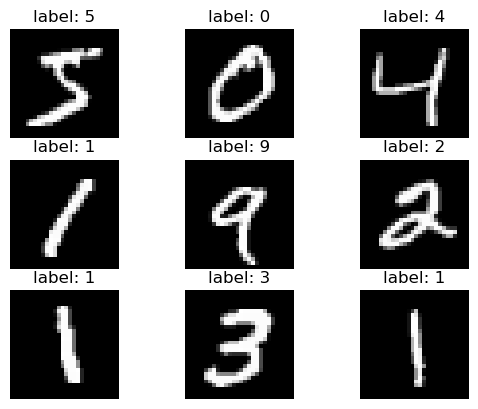

In [15]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
 
#loading
(train_X, train_y), (test_X, test_y) = mnist.load_data()
 
#shape of dataset
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))
 
#plotting
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(train_X[i], cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(f'label: {train_y[i]}')

[x] Single image compression using truncated SVD

(28, 28)
original image uses 784 values


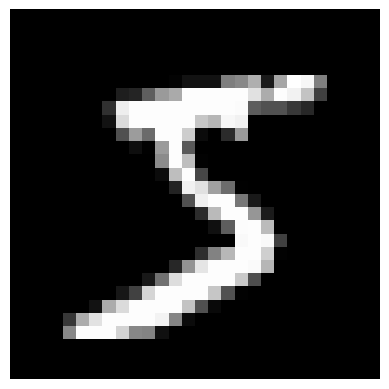

In [21]:
#convert to 2D image from 3 RGB channels
A = train_X[0].reshape(28, 28, 1)
X = np.mean(A, axis=2)
plt.imshow(X, cmap=plt.cm.gray)
plt.axis('off')
print(X.shape)
print(f'original image uses {np.prod(X.shape)} values')

In [7]:
from numpy.linalg import svd, pinv, inv

In [8]:
U,d,Vt = svd(X)
D = np.diag(d)

np.allclose(X, U @ D @ Vt)

True

Original image needs 28 x 28 = 784 values


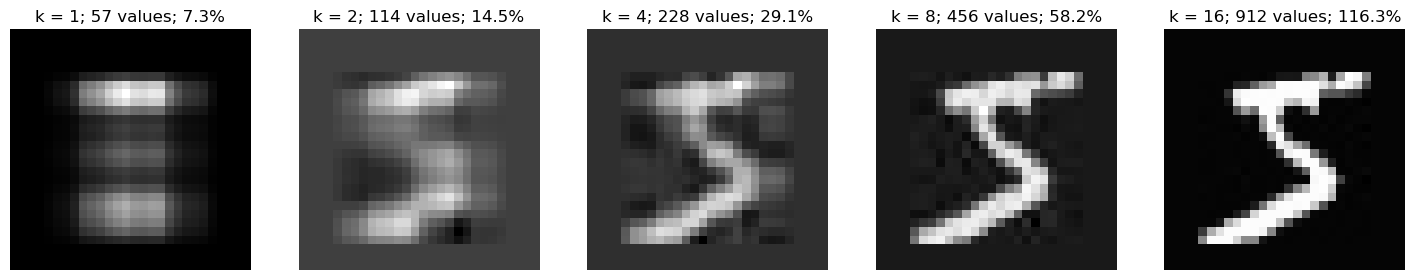

In [10]:
# k looping through sequence of powers of 2
m,n = X.shape
nm = np.prod(X.shape)
print(f'Original image needs {n} x {m} = {nm} values')
j = 0
plt.figure(figsize=(18, 8))
for k in [1 << i for i in range(5)]:
    plt.subplot(2,5,j+1)
    j += 1
    ## construct approximation of X with first $k$ dimensions
    X_approx = U[:,:k] @ D[:k,:k] @ Vt[:k,:]
    plt.imshow(X_approx, cmap=plt.cm.gray)
    plt.axis('off')
    storage = k*(m+n+1)
    plt.title(f'k = {k}; {storage} values; {storage/nm*100:.1f}%')

[x] SVD on whole dataset containing digits using 'eigendigits' space

In [16]:
print(train_X.shape)

# We need to reshape the dataset, so that each image is a vector
train_X_reshape = train_X.reshape((train_X.shape[0], 28*28))
train_X_reshape.shape

(60000, 28, 28)


(60000, 784)

(28, 28)
original image uses 784 values


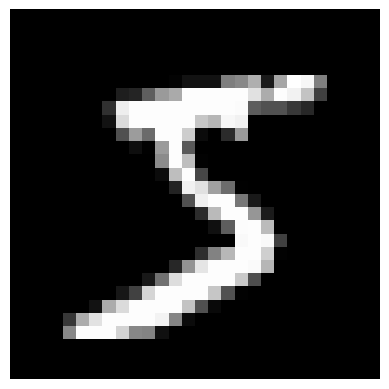

In [23]:
#convert to 2D image from 3 RGB channels
A = train_X_reshape[0].reshape(28, 28, 1)
X = np.mean(A, axis=2)
plt.imshow(X, cmap=plt.cm.gray)
plt.axis('off')
print(X.shape)
print(f'original image uses {np.prod(X.shape)} values')

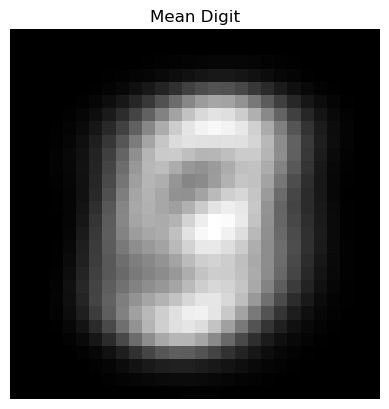

In [25]:
mean_digit = train_X_reshape.mean(axis=0)
plt.imshow(np.reshape(mean_digit, (28,28)), cmap=plt.cm.gray)
plt.title("Mean Digit")
plt.axis('off')
plt.show()

In [26]:
# center data
cX = train_X_reshape - mean_digit

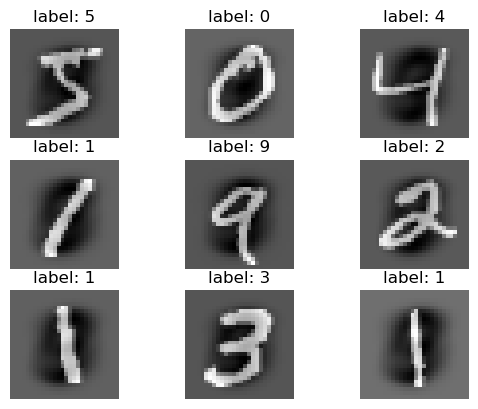

In [28]:
#plotting
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(cX[i].reshape(28,28,1), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(f'label: {train_y[i]}')

In [29]:
%%time
U, d, Vt = svd(cX, full_matrices=False)

CPU times: user 48.1 s, sys: 30.3 s, total: 1min 18s
Wall time: 6.25 s


In [30]:
U.shape, d.shape, Vt.shape

((60000, 784), (784,), (784, 784))

In [31]:
# check it worked..

svd_X = U @ np.diag(d) @ Vt

print(np.allclose(cX, svd_X, atol=1e-08))
print(np.allclose(cX, svd_X, atol=1e-03))

from scipy import stats

stats.describe(cX - svd_X, axis=None)

True
True


DescribeResult(nobs=47040000, minmax=(-6.639311322942376e-11, 8.054001909840736e-11), mean=6.386172348400886e-16, variance=3.289024325651197e-26, skewness=1.0426847122034462, kurtosis=2748.416482959796)

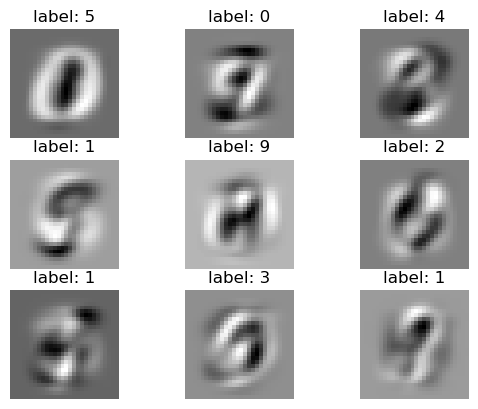

In [32]:
#plotting the first 9 eigenvectors
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(Vt[i].reshape(28,28,1), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title(f'label: {train_y[i]}')

In [33]:
n = train_X.shape[0]
i = np.random.randint(n) # select random image
alpha = U[i,:] @ np.diag(d)
print(alpha.shape)
print(alpha)

(784,)
[ 2.891e+01 -3.417e+02  3.582e+02  5.110e+02  2.465e+02  1.706e+02
 -1.259e+02 -2.789e+02  3.973e+02  1.580e+02 -4.621e+00 -4.474e+02
  7.237e+01  5.212e+02 -3.076e+02  7.688e+01 -1.959e+02 -8.280e+01
  1.319e+02  6.860e+01  4.711e+01 -2.561e+02 -1.115e+02  1.031e+02
 -2.527e+02 -4.529e+01  9.607e+01 -8.646e+01  2.645e+02  7.146e+01
  1.188e+02  1.657e+02 -3.627e+02  4.108e+01  2.810e+02 -2.098e+02
  1.804e+02 -1.889e+01  8.024e+01  9.886e+01  1.694e+02  1.330e+01
  1.731e+02  1.076e+01 -5.456e+01 -9.297e+01 -7.079e+01 -2.199e+02
  1.242e+02  4.114e+01 -7.791e+00  1.297e+02 -1.893e+01  1.080e+02
  4.741e+01  6.910e+01  1.680e+00  1.208e+02 -1.345e+02  9.919e+01
 -2.526e+01 -6.222e+01 -1.051e+02 -2.615e+00 -2.713e+01 -1.107e+02
  7.218e+01 -6.203e+01  2.295e+02 -1.822e+02 -1.381e+02 -2.951e+01
  1.930e+01  1.657e+02 -5.008e+01  1.420e+01 -1.929e+02 -1.413e+01
 -5.076e+01 -1.009e+02  3.960e+01  4.586e+01 -1.519e+01 -5.082e+01
  9.408e+01  2.084e+01  6.312e+00  1.364e+02 -1.219e+01

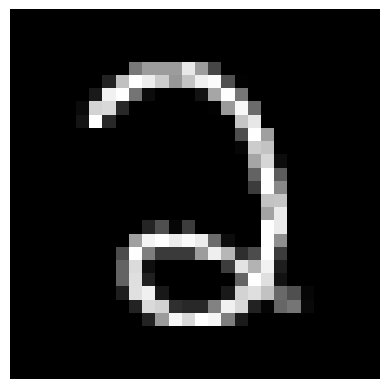

In [34]:
plt.imshow((mean_digit + cX[i,:]).reshape(28,28), cmap=plt.cm.gray)
plt.axis('off');

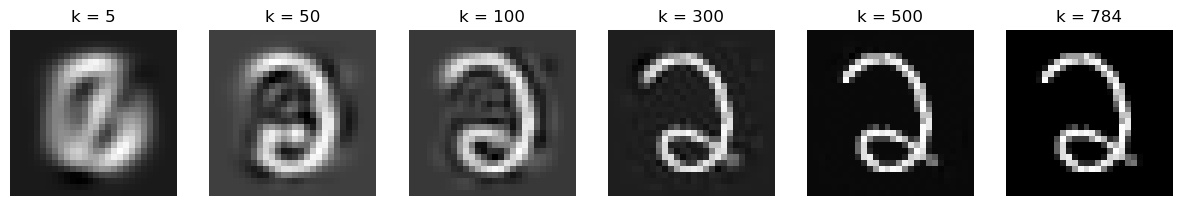

In [35]:
plt.figure(figsize=(15, 40))
j = 1
k_range = [5, 50, 100, 300, 500, Vt.shape[0]] 
for k in k_range:
    plt.subplot(1,len(k_range),j)
    j += 1
    reconstructed = mean_digit + alpha[:k] @ Vt[:k,:]
    plt.imshow(reconstructed.reshape(28,28), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('k = ' + str(k))

We can take an image from test_X, which is outside the training set, and see how it looks like in the eigendigit space. We can also see how the reconstruction looks like.

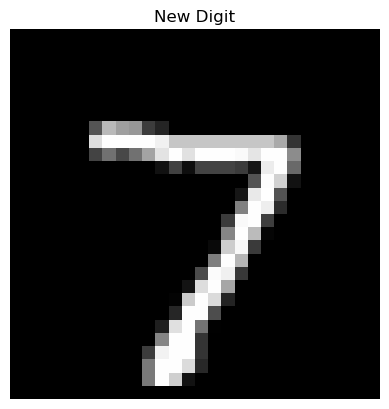

In [51]:
digit = test_X[0].reshape(28*28)
plt.imshow(np.reshape(digit, (28,28)), cmap=plt.cm.gray)
plt.title("New Digit")
plt.axis('off')
plt.show()

new_digit = digit.reshape(1, -1) - mean_digit
new_alpha = new_digit @ Vt.T
new_alpha = new_alpha.reshape(-1)

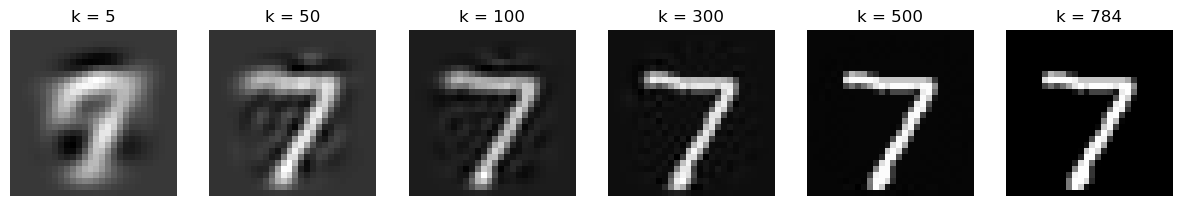

In [52]:
plt.figure(figsize=(15, 40))
j = 1
k_range = [5, 50, 100, 300, 500, Vt.shape[0]] 
for k in k_range:
    plt.subplot(1,len(k_range),j)
    j += 1
    reconstructed = mean_digit + new_alpha[:k] @ Vt[:k,:]
    plt.imshow(reconstructed.reshape(28,28), cmap=plt.cm.gray)
    plt.axis('off')
    plt.title('k = ' + str(k))

[x] 2D visualization of MNIST digits dataset

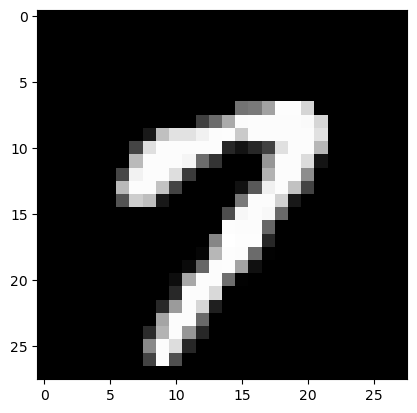

In [56]:
seven = train_X_reshape[train_y == 7][0]
plt.imshow(np.reshape(seven, (28,28)), cmap=plt.cm.gray)

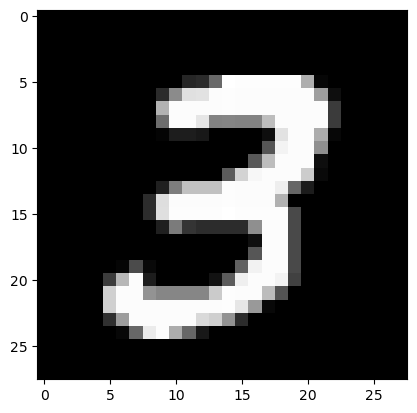

In [57]:
three = train_X_reshape[train_y == 3][0]
plt.imshow(np.reshape(three, (28,28)), cmap=plt.cm.gray)

In [58]:
sevens_idx = np.where(train_y == 7)[0]
threes_idx = np.where(train_y == 3)[0]

print(f'Found {len(sevens_idx)} sevens and {len(threes_idx)} threes')

Found 6265 sevens and 6131 threes


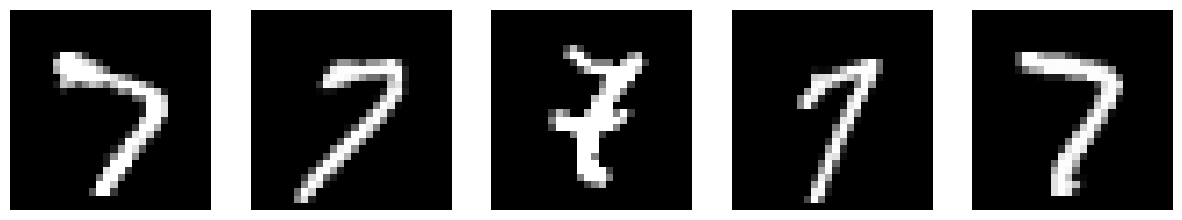

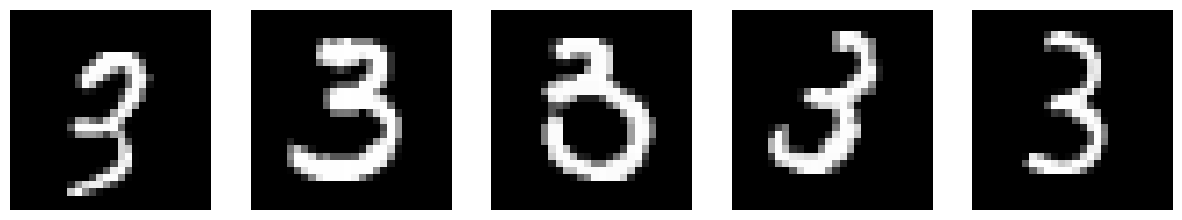

In [59]:
# show random images from both digits
import random

def show_pics(flist, k):
    plt.figure(figsize=(15, 40))
    for i, idx in enumerate(random.sample(list(flist), k)):
        plt.subplot(1, k, i+1)
        plt.imshow(train_X[idx,:,:], cmap=plt.cm.gray)
        plt.axis('off')
        
show_pics(sevens_idx, 5)
show_pics(threes_idx, 5)

In [60]:
# get coordinates for both using 2 eigendigits
eigen_modes = [4, 10]
def get_coord(flist):
    res = np.zeros((len(flist), 2))
    for i, idx in enumerate(list(flist)):
        x = train_X[idx,:,:].reshape(1 , -1) - mean_digit
        alpha = (x @ Vt.T).reshape(-1)
        res[i,:] = alpha[eigen_modes]
    return res
seven = get_coord(sevens_idx)
three = get_coord(threes_idx)

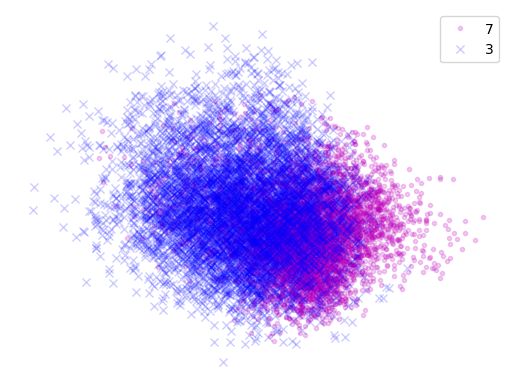

In [63]:
# plot them in 2D
plt.plot(seven[:,0], seven[:,1], '.', color='m', label='7', alpha=0.2)
plt.plot(three[:,0], three[:,1], 'x', color='b', label='3', alpha=0.2)
plt.axis('off')
plt.legend()